In [1]:
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score ,precision_score , recall_score , f1_score , confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## BoilerPlate Code

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
dirpath = '../Data/SMAI-Dataset-release/IIIT-CFW'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


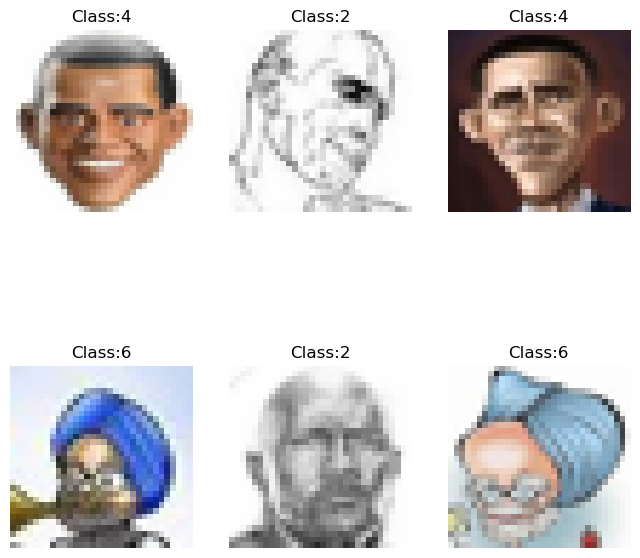

In [5]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

## PCA on IIIT-CFW

In [6]:
'''Flattening the data to get 32*32*3 = 3072 features for each image and performing SVD'''

X_reshaped = X.reshape(N,H*W*C).T # putting observations in columns
X_reshaped = X_reshaped - np.mean(X_reshaped , axis = 0)
# performing PCA on X
S = np.dot(X_reshaped,X_reshaped.T)
U, D, VT = np.linalg.svd(S)

In [7]:
'''Acquiring the PCA matrix (with sorted eigen values in descending order) and plotting Explained Variance'''

P = U.T # our PCA projection matrix
num_comps = np.arange(1 , X_reshaped.shape[0] + 1)
total_var = np.sum(D)
var_explained = np.cumsum(D)/total_var

fig = px.line(x=num_comps, y=var_explained, title='Variance Explained vs Number of Components')
fig.update_layout(xaxis_title='Number of Components', yaxis_title='Variance Explained')
fig.show()

In [26]:
'''A KNN classifier for comparing performances and return acc,prec,recall and f1 score'''

def KNNclassifier(X , y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 , shuffle=False)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred) , precision_score(y_test, y_pred, average='macro',zero_division=0) , recall_score(y_test, y_pred, average='macro',zero_division=0) , f1_score(y_test, y_pred, average='macro',zero_division=0) 



In [27]:
'''Plotting accuracy with PCA varying the number of components'''

acc_without,_ , _ , _ = KNNclassifier(X_reshaped.T , y)
print("Accuracy without PCA: ",acc_without)

acc_with_pca = []
num_comps = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1024 , 2048 , 3072]
for num_comp in num_comps:
    X_proj = np.dot(P[:num_comp] , X_reshaped)
    acc , _ , _ , _ = KNNclassifier(X_proj.T , y)
    acc_with_pca.append(acc)

fig = px.line(x=num_comps, y=acc_with_pca, title='Accuracy vs Number of Components')
fig.update_layout(xaxis_title='Number of Components', yaxis_title='Accuracy')
fig.add_hline(y=acc_without, line_dash="dot")
fig.show()

Accuracy without PCA:  0.005952380952380952


## For Pictionary Dataset (Assignment - 1)
Metrics come close to the values without PCA for around 100 principal components used , after that it probably starts introducing noise and metrics decrease upto 200 principal components.

In [28]:
'''Loading Data and acquiring features to get PCA matrix'''

data = np.load('../Data/pictionary_embeddings.npy' , allow_pickle=True)
resnet_feats = np.array([row[1] for row in data]).reshape(-1, 1024)
labels = np.array([row[3] for row in data])

res_reshaped = resnet_feats.T
S_res = np.dot(res_reshaped,res_reshaped.T)
U_res, D_res, VT_res = np.linalg.svd(S_res)
P_res = U_res.T # our PCA projection matrix

In [29]:
'''Plotting accuracy , precision , recall and f1 scores varying the number of components'''

acc_without , prec_without , recall_without , f1_without = KNNclassifier(resnet_feats , labels)
print("Accuracy of KNN classifier on ResNet features Without PCA: ", acc_without)
print("Precision of KNN classifier on ResNet features Without PCA: ", prec_without)
print("Recall of KNN classifier on ResNet features Without PCA: ", recall_without)
print("f1 of KNN classifier on ResNet features Without PCA: ", f1_without)


num_comps = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1024]
accs = [] 
precs = []
recalls = []
f1s = []
for num_comp in num_comps:
    res = np.dot(P_res[:num_comp], res_reshaped)
    acc , prec , recall , f1 = KNNclassifier(res.T , labels)
    accs.append(acc)
    precs.append(prec)
    recalls.append(recall)
    f1s.append(f1)

fig = px.line(x=num_comps, y=accs, title='Accuracy vs. Number of Components')
fig.update_layout(xaxis_title='Number of Components', yaxis_title='Accuracy')
fig.add_hline(y=acc_without, line_dash="dot",)
fig.show()

fig = px.line(x=num_comps, y=precs, title='Precision vs. Number of Components')
fig.update_layout(xaxis_title='Number of Components', yaxis_title='Precision')
fig.add_hline(y=prec_without, line_dash="dot",)
fig.show()

fig = px.line(x=num_comps, y=recalls, title='Recall vs. Number of Components')
fig.update_layout(xaxis_title='Number of Components', yaxis_title='Recall')
fig.add_hline(y=recall_without, line_dash="dot",)
fig.show()

fig = px.line(x=num_comps, y=f1s, title='F1 vs. Number of Components')
fig.update_layout(xaxis_title='Number of Components', yaxis_title='F1')
fig.add_hline(y=f1_without, line_dash="dot",)
fig.show()

Accuracy of KNN classifier on ResNet features Without PCA:  0.17333333333333334
Precision of KNN classifier on ResNet features Without PCA:  0.10798419424945507
Recall of KNN classifier on ResNet features Without PCA:  0.1259883198562444
f1 of KNN classifier on ResNet features Without PCA:  0.09772649264442008


## Drawer and Guesser Pictionary

In [12]:
drawer = pd.read_csv('../Data/PictionaryDataset/drawer_attributes.csv')
guesser = pd.read_csv('../Data/PictionaryDataset/guesser_attributes.csv')

drawer.head()
guesser.head()

,g_guesser,g_noofmessage_median,g_firstmessagetime_median,g_lastmessagetime_median,g_rangemessagetime_median,g_pcgamesconfusion,g_entropy
0,10,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,36,1.0,25.367172,39.041594,0.000000,0.0,0.000000
2,14,2.0,12.988740,51.351317,38.362577,1.0,0.693147
3,26,3.5,20.622346,64.718058,44.095712,0.0,1.242453
4,40,3.0,30.339558,78.943003,48.603445,0.0,1.098612


In [13]:
X_drawer = np.array(drawer.iloc[:, 1:])
y_drawer = np.array(drawer.iloc[:, 0])

X_guesser = np.array(guesser.iloc[:, 1:])
y_guesser = np.array(guesser.iloc[:, 0])

### Plotting PCA vs Attributes for Drawer which show the component of the original attribute that the new PCA has taken 

1. First axis represents area of canvas used
2. Second , Third and Fourth basically contain information about stroke time with increasing importance of first stroke time and decreasing of last stroke time
3. Fifth majorly highlights thumbs up usage and erase highlight 
4. Sixth majorly highlights thumbs down usage with some information about stroke frequency
5. Seventh majorly contains information about stroke frequency with some info about thumbs down usage
6. Eight again contains some noisy info about stroke freq , thumbs and erase highlight usage

In [14]:
X_drawer_reshaped = X_drawer.T # putting observations in columns
# performing PCA on X
S_drawer = np.dot(X_drawer_reshaped,X_drawer_reshaped.T)
U_drawer, D_drawer, VT_drawer = np.linalg.svd(S_drawer)
P_drawer = U_drawer.T # our PCA projection matrix

In [15]:
import plotly.subplots as sp
import plotly.graph_objs as go

# Create subplots with a 2x4 grid
fig = sp.make_subplots(rows=2, cols=4)
x = np.arange(1, 9)

plots = []
for i in range(1 , 9):
    plot = go.Scatter(x = x, y=abs(P_drawer[i-1]) ,mode = 'lines+markers', name='Principal Component Axis {}'.format(i))
    fig.add_trace(plot, row=(i-1)//4 + 1, col=(i-1)%4 + 1)
    

# Update the layout as needed
fig.update_layout(title_text="Principal Component Axes vs Attributes of Drawer")

# Show the figure
fig.show()
        

In [16]:
Y = np.dot(P_drawer[:2] , X_drawer_reshaped)
Y = Y.T
fig = px.scatter(x=Y[:,0], y=Y[:,1], color=y_drawer)
fig.update_layout(xaxis_title='PC1', yaxis_title='PC2',title_text="2D Scatter Plot of Drawer Attributes with 2 Principal Components")
fig.show()

### Plotting PCA vs Attributes for Guesser which show the component of the original attribute that the new PCA has taken 

1. First , Second and Third axes represents guess time with decreasing importance of last guess time and increasing importance of first message time
2. Fourth axis contains information about number of guesses
3. Fifth majorly highlights entropy of guesses
4. Sixth majorly highlights percentage of games with confusion 


In [17]:
X_guesser_reshaped = X_guesser.T # putting observations in columns
# performing PCA on X
S_guesser = np.dot(X_guesser_reshaped,X_guesser_reshaped.T)
U_guesser, D_guesser, VT_guesser = np.linalg.svd(S_guesser)
P_guesser = U_guesser.T # our PCA projection matrix

In [18]:
import plotly.subplots as sp
import plotly.graph_objs as go

# Create subplots with a 2x4 grid
fig = sp.make_subplots(rows=2, cols=4)
x = np.arange(1, X_guesser.shape[1]+1)

plots = []
for i in range(1 , X_guesser.shape[1]+1):
    plot = go.Scatter(x = x, y=abs(P_guesser[i-1]) ,mode = 'lines+markers', name='Principal Component Axis {}'.format(i))
    fig.add_trace(plot, row=(i-1)//4 + 1, col=(i-1)%4 + 1)
    

# Update the layout as needed
fig.update_layout(title_text="Principal Component Axes vs Attributes of Drawer")

# Show the figure
fig.show()
        

In [19]:
Y = np.dot(P_guesser[:2] , X_guesser_reshaped)
Y = Y.T
fig = px.scatter(x=Y[:,0], y=Y[:,1], color=y_guesser)
fig.update_layout(xaxis_title='PC1', yaxis_title='PC2',title_text="2D Scatter Plot of Drawer Attributes with 2 Principal Components")
fig.show()